# SPACE RACE

##### Data Exploration & Visualisation of the global space race from 1957 using space mission data.
##### Looking over Kaggle, I found a dataset that shows the space missions from 1957 to 2020.

[Kaggle Data](https://www.kaggle.com/datasets/sefercanapaydn/mission-launches/data)

Comments and Markdowns added for readability

In [1]:
#Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from iso3166 import countries

In [2]:
#Read the csv data into a pandas dataframe
missions_df = pd.read_csv('mission_launches.csv')

In [3]:
#For a holistic view of the data 
missions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


In [4]:
missions_df.head()

,Unnamed: 0.1,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


## Data Cleaning

In [5]:
#Identifying missing values and duplicates
print(f'Are there Nan Values?:{missions_df.isna().values.any()} ')
print(f'Are there Duplicates Values?:{missions_df.duplicated().values.any()} ')

Are there Nan Values?:True 
Are there Duplicates Values?:False 


In [6]:
missions_df.isna().sum()

Unnamed: 0.1         0
Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64

In [7]:
#Eliminating Nan and coverting data type of the price
missions_df['Price'] = pd.to_numeric(missions_df.Price, errors="coerce").fillna(0)
missions_df['Price'] = missions_df.Price.replace(",", "", regex=True)
missions_df['Price'] = missions_df.Price.astype(float)

In [8]:
missions_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

## Data Extraction

#### Date Formatting

In [9]:
missions_df['Date'] = pd.to_datetime(missions_df.Date, utc=True, errors="coerce")

In [10]:
missions_df['Year'] = missions_df.Date.dt.year
missions_df['Year'] = missions_df.Year.fillna(0).astype(int)
missions_df = missions_df[missions_df.Year != 0]

In [11]:
print(f'Most Recent year in the dataset: {missions_df['Year'].max()}')
print(f'Oldest year in the dataset: {missions_df['Year'].min()}')

Most Recent year in the dataset: 2020
Oldest year in the dataset: 1957


In [12]:
missions_df['Date'] = missions_df['Date'].dt.tz_convert('UTC').dt.tz_localize(None)
missions_df['Calendar_Month'] = missions_df['Date'].dt.to_period('M')

In [13]:
missions_df['Month'] = missions_df['Date'].dt.month_name()
missions_df['Month_Number'] = missions_df['Date'].dt.month

#### Location Mapping

In [14]:
missions_df['Country'] = missions_df.Location.str.split(",").str[-1]

In [15]:
#Updating Country Names and Mapping Location
missions_df['Country'] = missions_df.Country.str.strip()

missions_df['Country'] = missions_df.Country.replace({
    'Shahrud Missile Test Site': 'Iran, Islamic Republic of',
    'New Mexico': 'United States of America',
    'Yellow Sea': 'China',
    'Pacific Missile Range Facility': 'United States of America',
    'Pacific Ocean': 'United States of America',
    'Barents Sea': 'Russian Federation',
    'Gran Canaria': 'Spain',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Russia': 'Russian Federation',
    'Iran': 'Iran, Islamic Republic of',
    'USA': 'United States of America'
})

In [16]:
#Extracting country codes from location data
missions_df['Country_Code'] = missions_df.Country.apply(lambda x: (countries.get(x).alpha3))

In [17]:
print(f'There are {missions_df['Country'].nunique()} countries with {missions_df['Country_Code'].nunique()} unique country codes')

There are 16 countries with 16 unique country codes


#### Organisational Classification

In [18]:
#Location mapping above was done procedurally. Assigning agency status would be done by a function
def agency_status(org):
    private_orgs = {
        'lockheed', 'land launch', 'northrop', 'arianespace', 'i-space',
        'boeing', 'martin marietta', 'expace', 'exos', 'virgin orbit',
        'spacex', 'general dynamics','douglas', 'rocket lab', 'ils',
        'blue origin', 'sea launch', 'onespace', 'landspace', 'eurockot'
    }

    government_orgs = {
        'casic', 'asi', 'src', 'casc', 'yuzhmash', 'cecles', 'kosmotras',
        'mhi', 'us navy', 'kari', 'okb-586', 'us air force', 'khrunichev',
        'ut', 'jaxa', 'isa', 'irgc', 'roscosmos', 'esa', 'rvsn ussr', 'vks rf',
        'nasa', 'eer', 'rae', 'cnes', 'ula', 'sandia', 'iai', 'starsem',
        'mitt', 'aeb', 'isro', 'amba', "arm??e de l'air", 'isas', 'kcst'
    }

    if org.lower() in private_orgs:
        return 'Private'
    elif org.lower() in government_orgs:
        return 'Government'
    else:
        return 'Unknown'

In [19]:
#Using the function to derive a column for the organisational status
missions_df['Agency_Type'] = missions_df.Organisation.apply(agency_status)

In [20]:
print(missions_df['Agency_Type'].value_counts())

Agency_Type
Government    3027
Private       1171
Name: count, dtype: int64


#### Expenditure Estimation

In [21]:
#To account for absent price data
#Using the median as mean makes the data susceptible to deviations from outliers
missions_df['Price_Filled'] = missions_df.Price
missions_df.loc[missions_df['Price_Filled'] == 0, 'Price_Filled'] = np.nan

missions_df['Price_Filled'] = missions_df.groupby('Agency_Type').Price_Filled.transform(
    lambda x: x.fillna(x.median())
)

## Data Exploration and Visualisation

#### Number of Missions over Time

In [22]:
launches_per_month = missions_df.groupby('Calendar_Month').size().reset_index(name='Launch_Count')
launches_per_month['Calendar_Month'] = launches_per_month['Calendar_Month'].dt.to_timestamp()
peak_month = launches_per_month.loc[launches_per_month['Launch_Count'].idxmax()]
print(f"🚀 The month with the highest number of launches was: {peak_month['Calendar_Month'].strftime('%B %Y')} with {peak_month['Launch_Count']} launches.")


🚀 The month with the highest number of launches was: April 1968 with 16 launches.


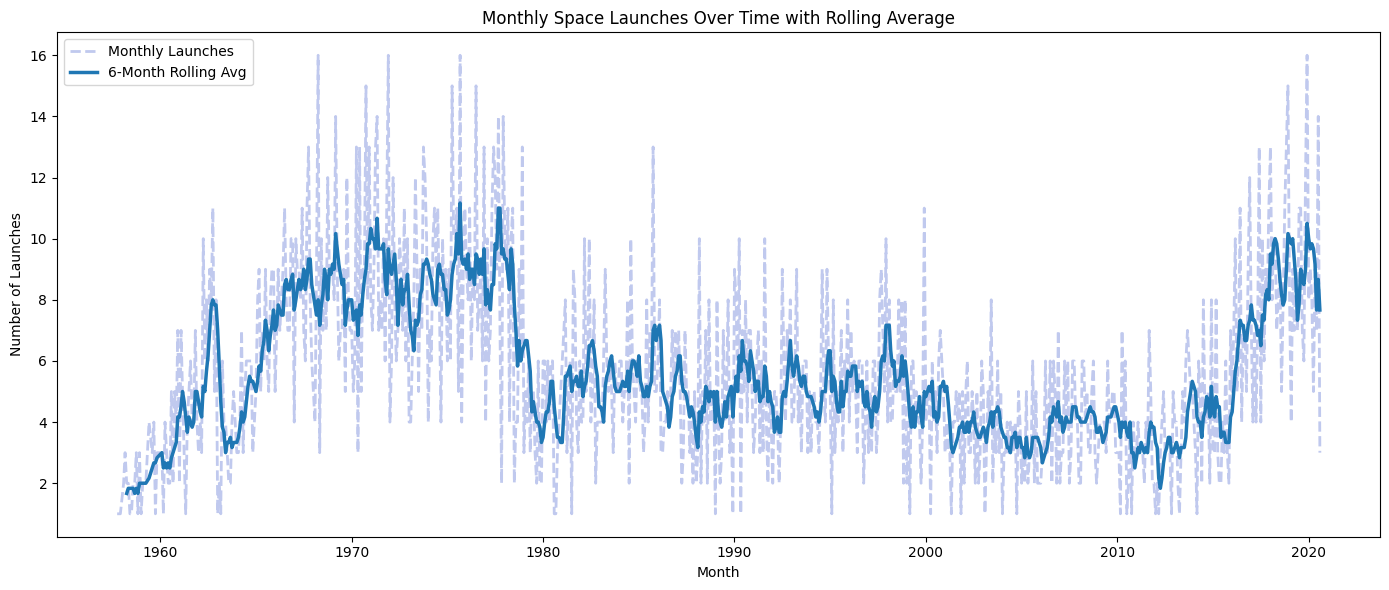

In [23]:
launches_per_month['Rolling_Avg'] = launches_per_month['Launch_Count'].rolling(window=6).mean()

fig1 = plt.figure(figsize=(14, 6))
sns.lineplot(data=launches_per_month, x='Calendar_Month', y='Launch_Count', label='Monthly Launches', linewidth=2, linestyle='--', color='#C0C9EE' )
sns.lineplot(data=launches_per_month, x='Calendar_Month', y='Rolling_Avg', label='6-Month Rolling Avg', linewidth=2.5)

plt.title('Monthly Space Launches Over Time with Rolling Average')
plt.xlabel('Month')
plt.ylabel('Number of Launches')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
monthly_totals = missions_df.groupby(['Month_Number', 'Month']).size().reset_index(name='Launch_Count')
monthly_totals = monthly_totals.sort_values('Month_Number')
monthly_totals

,Month_Number,Month,Launch_Count
0,1,January,265
1,2,February,323
2,3,March,349
3,4,April,366
4,5,May,320
5,6,June,386
6,7,July,347
7,8,August,358
8,9,September,354
9,10,October,375


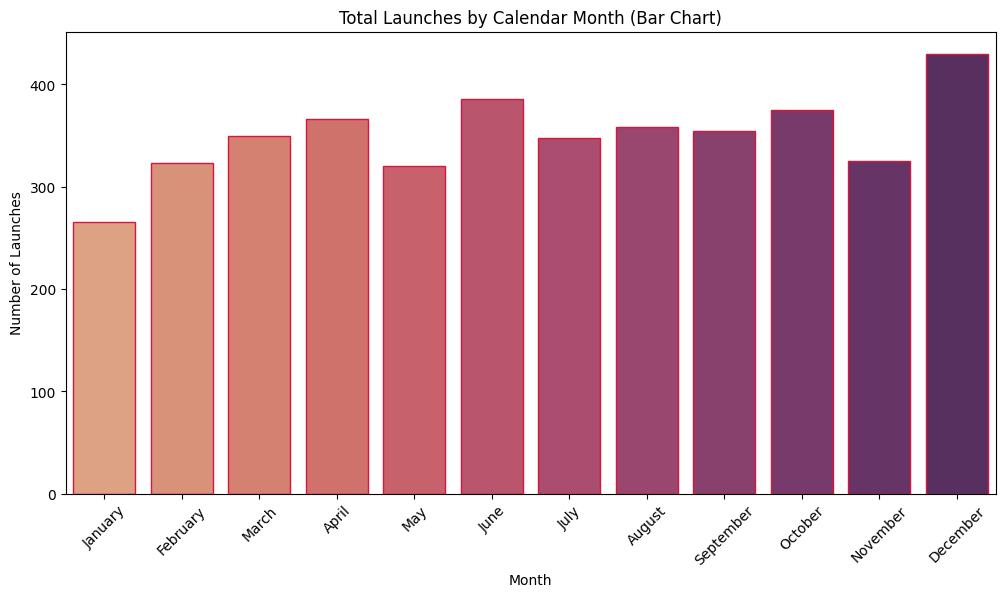

In [25]:
fig2 = plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_totals,
    x='Month',
    y='Launch_Count',
    order=monthly_totals.sort_values('Month_Number')['Month'],
    edgecolor='crimson',
    palette='flare',
    hue='Month',
    legend=False,
    dodge=False
 )
plt.title('Total Launches by Calendar Month (Bar Chart)')
plt.xlabel('Month')
plt.ylabel('Number of Launches')
plt.xticks(rotation=45)
plt.show()

The month with the highest number of recorded launches is December. This may be attributed to year-end goals, meeting budget deadlines and reporting cycles. June has favourable weather conditions in the nothern hemisphere where key sites are stationed. October similarly has excellent weather globally neither to hot nor stormy in most regions.

In [26]:
missions_per_year = missions_df.groupby('Year').size().reset_index(name='Mission_Count')
missions_per_year

,Year,Mission_Count
0,1957,3
1,1958,22
2,1959,20
3,1960,38
4,1961,52
...,...,...
59,2016,88
60,2017,90
61,2018,117
62,2019,107


In [27]:
fig3 = px.line(missions_per_year, x='Year', y='Mission_Count',
              title='Interactive View: Number of Space Missions Over Time')

fig3.update_layout(
    xaxis=dict(rangeslider=dict(visible=True), title='Year'),
    yaxis_title='Mission Count'
)

fig3.show()

<p>In 1957 the USSR (now the Russian Federation) launched Sputnik, officially beginning the space race. This can be found in the datset.

In 1962, the world came close to a nuclear war heightening rocket development. Peace treaties were signed in 1963, leading to a sharp decline. The cold war ushered in the  development of military defence systems, surveillance, information systems and communication satellites.

However, how many of these missions were actually <b>successful?</b></p>

#### Annual Success Rates

In [28]:
#To determine Success rates
missions_df['Success_Binary'] = missions_df.Mission_Status.apply(lambda x: 1 if x == 'Success' else 0)

success_rate = missions_df.groupby('Year').Success_Binary.mean().reset_index()
success_rate['Success_Percent'] = success_rate.Success_Binary * 100
success_rate

,Year,Success_Binary,Success_Percent
0,1957,0.666667,66.666667
1,1958,0.272727,27.272727
2,1959,0.400000,40.000000
3,1960,0.500000,50.000000
4,1961,0.615385,61.538462
...,...,...,...
59,2016,0.954545,95.454545
60,2017,0.922222,92.222222
61,2018,0.965812,96.581197
62,2019,0.934579,93.457944


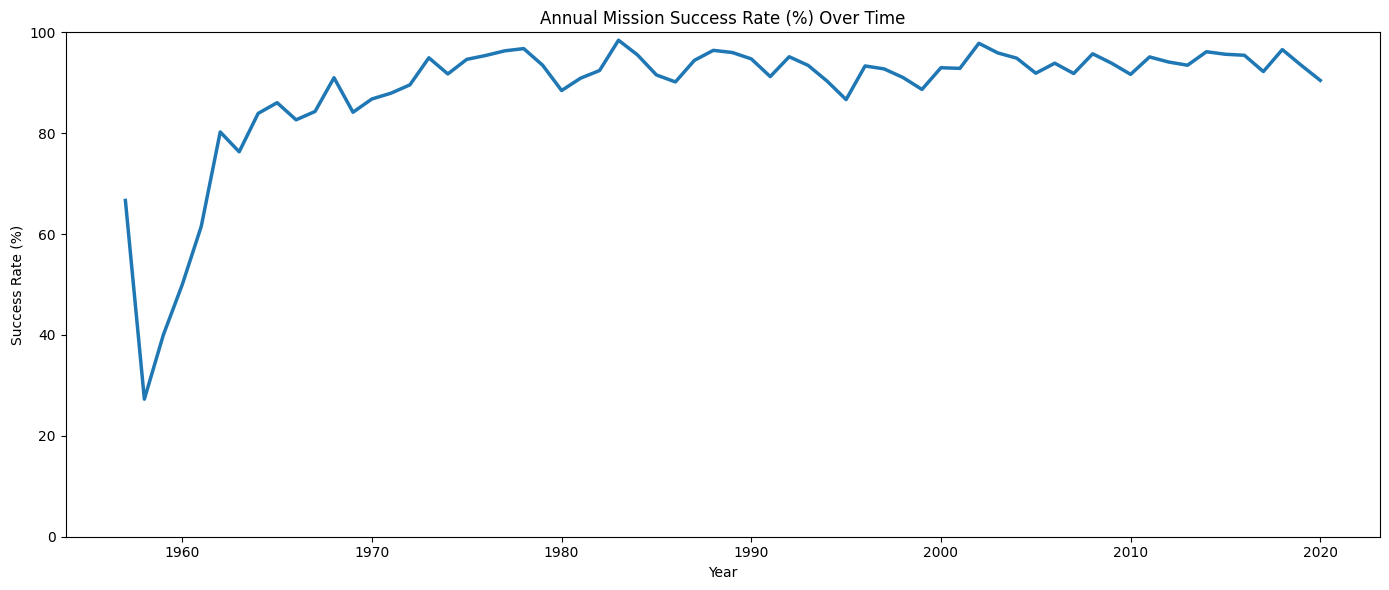

In [29]:
fig4, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=success_rate, x='Year', y='Success_Percent', linewidth=2.5, ax=ax)
ax.set_title('Annual Mission Success Rate (%) Over Time')
ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Year')
ax.set_ylim(0, 100)
fig4.tight_layout()

<p>Shows a declining success rate till around the start of the 60's. But it does not quite make sense of the complete picture.</p>

In [30]:
annual_status = missions_df.groupby(['Year', 'Mission_Status']).size().unstack(fill_value=0)
annual_status

Mission_Status,Failure,Partial Failure,Prelaunch Failure,Success
Year,,,,
1957,1,0,0,2
1958,14,2,0,6
1959,9,3,0,8
1960,19,0,0,19
1961,17,3,0,32
...,...,...,...,...
2016,2,1,1,84
2017,5,2,0,83
2018,2,2,0,113


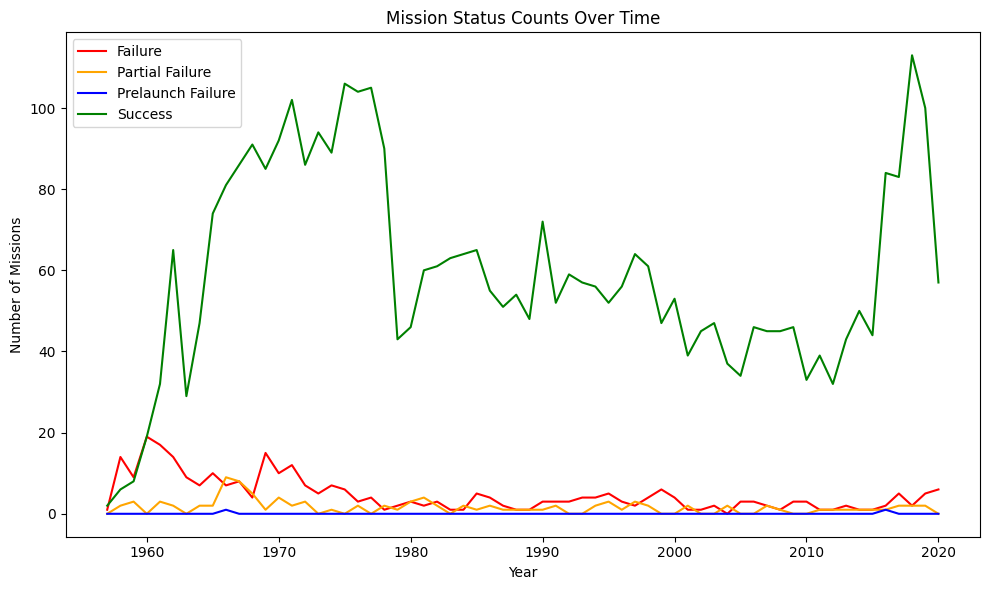

In [31]:
fig5, ax = plt.subplots(figsize=(10, 6))

ax.plot(annual_status.index, annual_status['Failure'], label='Failure', color='red')
ax.plot(annual_status.index, annual_status['Partial Failure'], label='Partial Failure', color='orange')
ax.plot(annual_status.index, annual_status['Prelaunch Failure'], label='Prelaunch Failure', color='blue')
ax.plot(annual_status.index, annual_status['Success'], label='Success', color='green')

ax.legend()
ax.set_title('Mission Status Counts Over Time')
ax.set_ylabel('Number of Missions')
ax.set_xlabel('Year')
fig5.tight_layout()

<p>There were more failures than successful attemtst up until 1960 when the number of succesful missions superceded the number of space missions that failed.</p>
<p>This explains the trend of increased success rates seen after the 1960</p>

#### Country Compaarison

In [32]:
#Creating a dataframe of countries and their mission status to chart successes
success_by_country = pd.crosstab(missions_df.Country_Code, missions_df.Mission_Status)
success_by_country['Total_Missions'] = success_by_country.sum(axis=1)
success_by_country.sort_values('Total_Missions', ascending=False, inplace=True)
success_by_country.reset_index(inplace=True)
success_by_country

Mission_Status,Country_Code,Failure,Partial Failure,Prelaunch Failure,Success,Total_Missions
0,USA,119,33,1,1204,1357
1,RUS,56,30,0,1268,1354
2,KAZ,69,20,1,589,679
3,FRA,13,5,0,285,303
4,CHN,16,6,0,243,265
5,JPN,6,3,0,113,122
6,IND,8,5,0,62,75
7,NZL,2,0,0,11,13
8,KEN,0,0,0,9,9
9,AUS,3,0,0,2,5


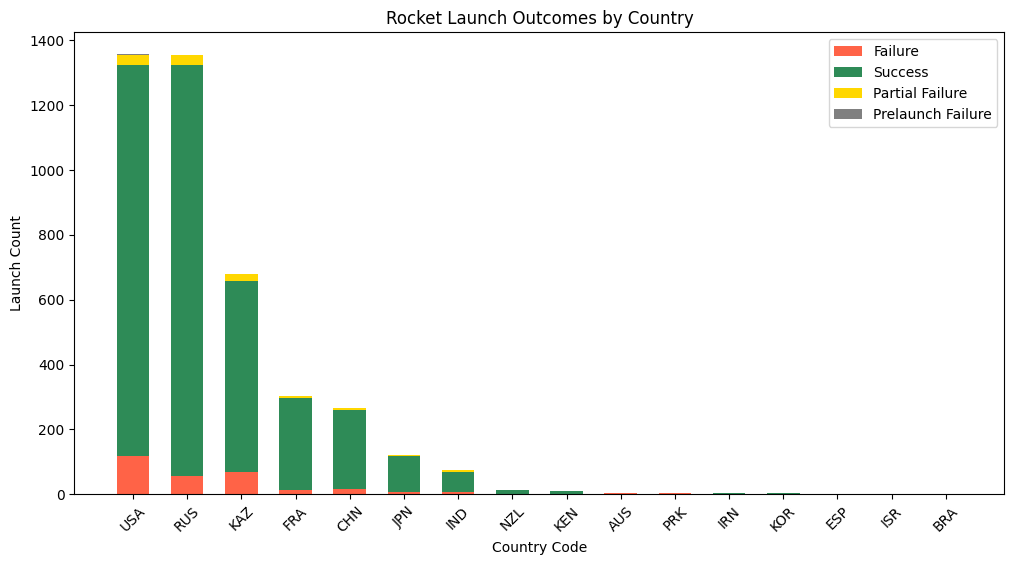

In [33]:
x = np.arange(len(success_by_country))
bar_width = 0.6

failure = success_by_country['Failure']
success = success_by_country['Success']
partial_failure = success_by_country['Partial Failure']
prelaunch_failure = success_by_country['Prelaunch Failure']

fig6, ax = plt.subplots(figsize=(12, 6))

ax.bar(x, failure, bar_width, label='Failure', color='tomato')
ax.bar(x, success, bar_width, bottom=failure, label='Success', color='seagreen')
ax.bar(x, partial_failure, bar_width, bottom=failure + success, label='Partial Failure', color='gold')
ax.bar(x, prelaunch_failure, bar_width, bottom=failure + success + partial_failure, label='Prelaunch Failure', color='gray')

ax.set_xticks(x)
ax.set_xticklabels(success_by_country['Country_Code'], rotation=45)
ax.set_xlabel('Country Code')
ax.set_ylabel('Launch Count')
ax.set_title('Rocket Launch Outcomes by Country')
ax.legend()

fig5.tight_layout()

<p>The bar chart shows the full barchart of the missions launched per country from 1957. Each bar subdivided into its mission status showing what fraction of the missions were successful.
Although America has a higher launch count than Russia, the Russian Federation seems to have launched more successful missions as at 2020. This chart however fails to capture the progress over time</p>

In [34]:
#Number of missions done by each Country per year
annual_country = missions_df.groupby(['Year', 'Country']).size().reset_index(name='Missions')

#Creating a separate index for the df
#Prior to this, animated bar chart below only included countries that had launched as at 1957.
all_years = range(annual_country.Year.min(), annual_country.Year.max() + 1)
all_countries = annual_country.Country.unique()

complete_index = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'Country'])

annual_country = annual_country.set_index(['Year', 'Country']).reindex(complete_index, fill_value=0).reset_index()

annual_country['Cumulative_Missions'] = (
    annual_country.groupby('Country').Missions.cumsum()
)

In [35]:
fig7 = px.bar(
    annual_country,
    x="Cumulative_Missions",
    y="Country",
    color="Country",
    animation_frame="Year",
    title="Space Race Over Time (Animated) - All Countries",
    range_x=[0, annual_country.Cumulative_Missions.max() + 100],
    height=700
)
fig7.update_layout(yaxis={'categoryorder': 'total ascending'})
fig7.show()

<p>America had a global dominance in number of explorations launched until 1973. Russia and Kazakhstan(then the USSR) swiftly took the lead well into the 21st century where America caught up. This may be due to the emergence of private companies engaging in space exploration. This could also explain the late growth in French launches.</p>
<p>To visualise geographical distribution of space contributions we can make use of a Plotly Chloroploth Map</p>

In [36]:
country_counts = missions_df.Country.value_counts().reset_index()
country_counts.columns = ['Country', 'Mission_Count']

fig8 = px.choropleth(
    country_counts,
    locations='Country',
    locationmode='country names',
    color='Mission_Count',
    color_continuous_scale='Viridis',
    title='Global Distribution of Space Missions by Country'
)
fig8.update_layout(geo=dict(showframe=False, projection_type='natural earth'))
fig8.show()

The map shows the geographic spread of missions irrespective of the mission outcome. The global distribution of the failures can be seen below.

In [37]:
success_by_country['Total_Failures'] = success_by_country['Failure'] + success_by_country['Partial Failure'] + success_by_country['Prelaunch Failure']
fig9 = px.choropleth(
    success_by_country,
    locations='Country_Code',
    locationmode='ISO-3',
    color='Total_Failures',
    color_continuous_scale='YlOrRd',
    title='Global Distribution of Failed Space Missions'
)
fig9.update_layout(geo=dict(showframe=False, projection_type='natural earth'))
fig9.show()

<p>Clearly shows the geographical distribution of the launches but is limited to a country scale.
Now to examine if any particular launch sites were favoured.</p>

#### Launch Site Popularity

In [38]:
missions_df['Location'] = missions_df.Location.str.strip()


top_sites = missions_df.Location.value_counts().head(20).reset_index()
top_sites.columns = ['Launch_Site', 'Launch_Count']

top_sites.head()

,Launch_Site,Launch_Count
0,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",224
1,"Site 132/1, Plesetsk Cosmodrome, Russia",208
2,"Site 43/4, Plesetsk Cosmodrome, Russia",202
3,"Site 41/1, Plesetsk Cosmodrome, Russia",198
4,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",190


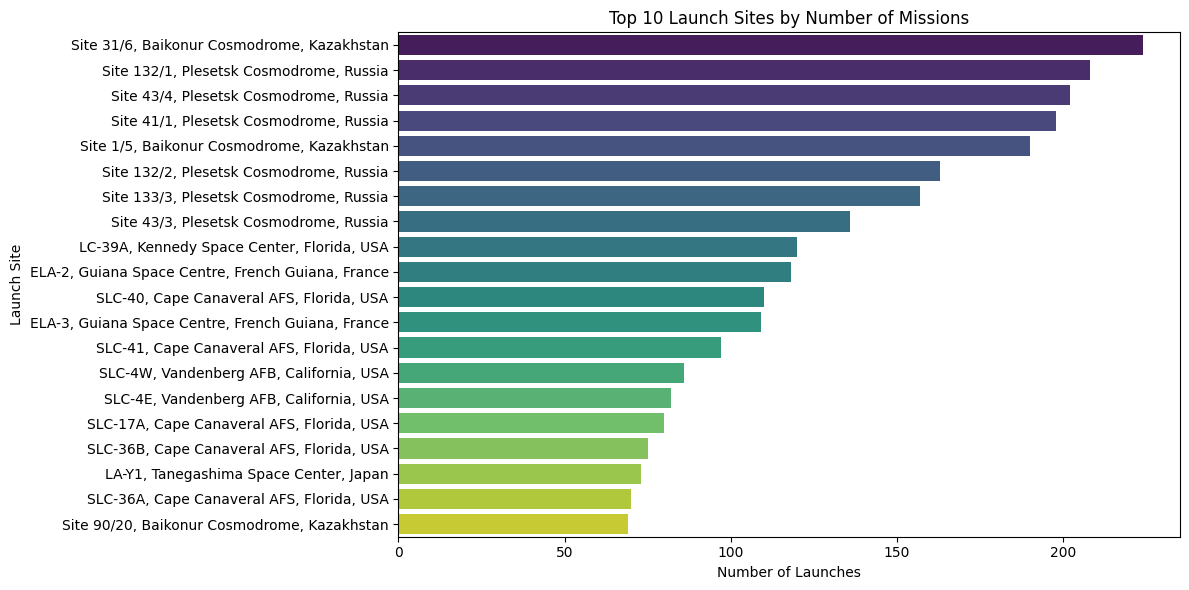

In [39]:

fig10 = plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_sites,
    x='Launch_Count',
    y='Launch_Site',
    hue='Launch_Site',
    palette='viridis',
    dodge=False,
    legend=False        
)
plt.title('Top 10 Launch Sites by Number of Missions')
plt.xlabel('Number of Launches')
plt.ylabel('Launch Site')
plt.tight_layout()
plt.show()

<p>The bar chart animated over time showed an American dominance in space launches when cummulated, yet this chart seems to show a Kazakhstani and Russian lead. Perhaps this is due to a spike during a certain time period. Analysing through a heatmap may provide clarity</p>

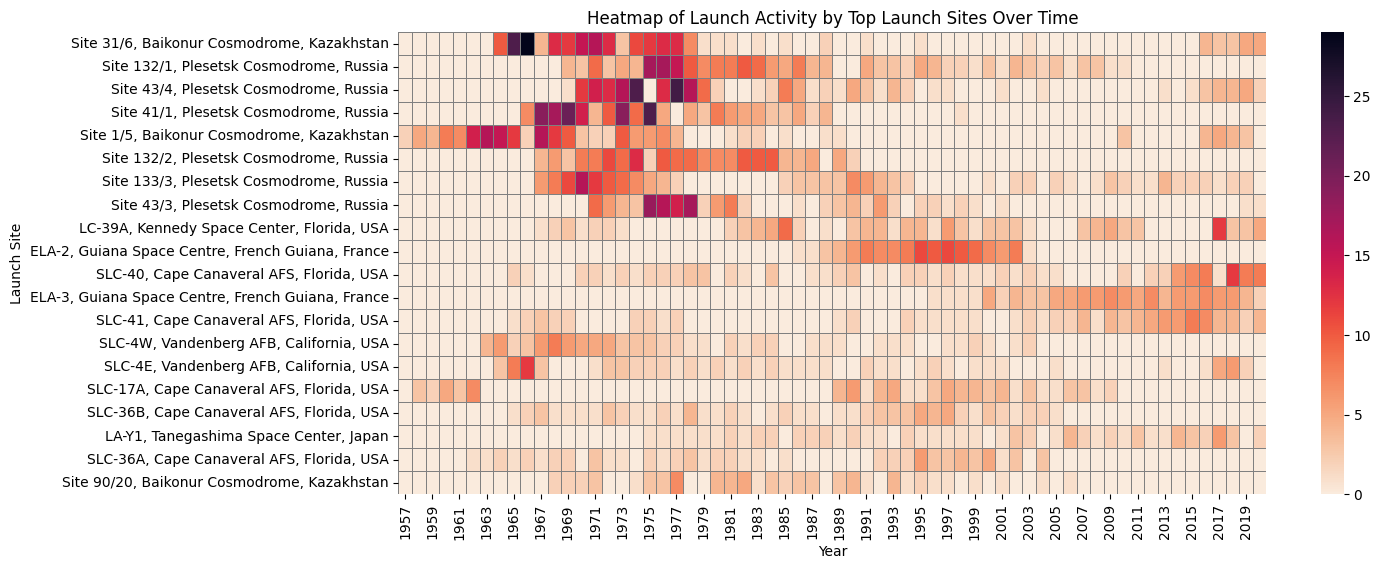

In [40]:
site_year = missions_df.groupby(['Location', 'Year']).size().unstack(fill_value=0)

top_launch_sites = missions_df['Location'].value_counts().head(20).index
site_year_top = site_year.loc[top_launch_sites]

fig11 = plt.figure(figsize=(14, 6))
sns.heatmap(site_year_top, cmap='rocket_r', linewidths=0.5, linecolor='gray')
plt.title('Heatmap of Launch Activity by Top Launch Sites Over Time')
plt.xlabel('Year')
plt.ylabel('Launch Site')
plt.show()


<p>The sites in Russia and Kazakhstan(then part of the USSR) although heavily active in the 60's and 70's, saw a decline in launches at the end of the 1970s.</p>
<p>Perhaps specific occurences had part to play in this decline.</p>

#### Cold War (The USA vs the USSR)

In [41]:
df_filtered = missions_df[missions_df['Country_Code'].isin(['USA', 'RUS'])]

df_grouped = df_filtered.groupby(['Year', 'Country_Code', 'Success_Binary']).size().reset_index(name='Count')

df_pivot = df_grouped.pivot_table(index='Year', columns=['Country_Code', 'Success_Binary'], values='Count', fill_value=0)

df_pivot

Country_Code    RUS        USA      
Success_Binary    0    1     0     1
Year                                
1957            0.0  0.0   1.0   0.0
1958            0.0  0.0  12.0   5.0
1959            0.0  0.0  10.0   6.0
1960            0.0  0.0  14.0  16.0
1961            2.0  0.0  16.0  27.0
...             ...  ...   ...   ...
2016            0.0  6.0   1.0  24.0
2017            1.0  5.0   0.0  29.0
2018            0.0  8.0   1.0  33.0
2019            0.0  9.0   3.0  24.0
2020            0.0  3.0   1.0  20.0

[64 rows x 4 columns]

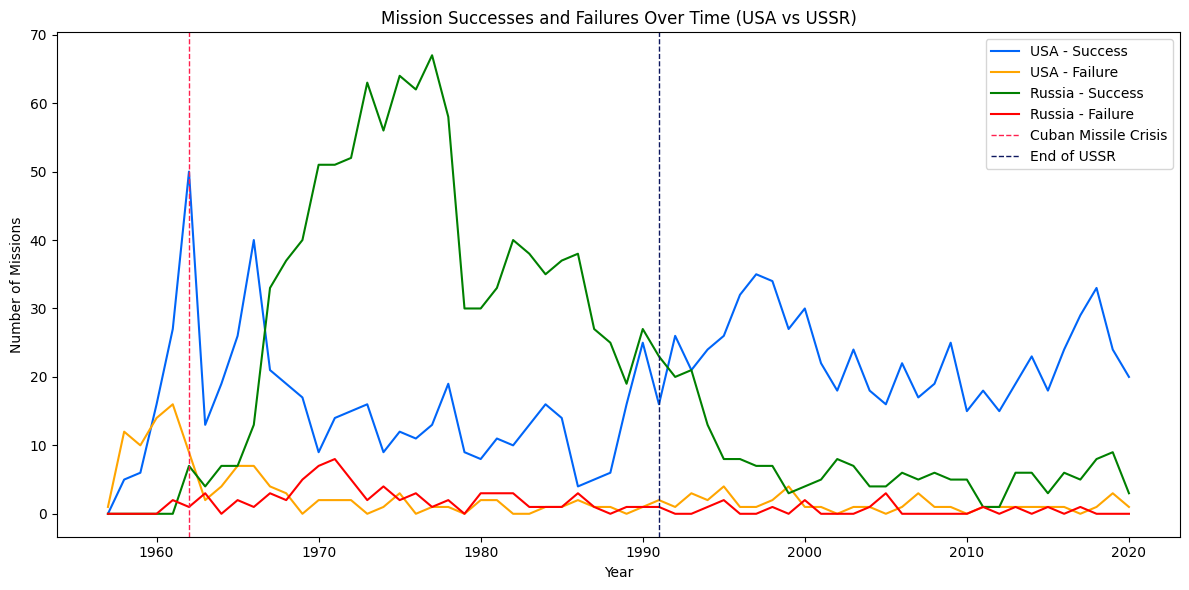

In [42]:
fig12 = plt.figure(figsize=(12, 6))
plt.plot(df_pivot.index, df_pivot[('USA', 1)], label='USA - Success', color='#0065F8')
plt.plot(df_pivot.index, df_pivot[('USA', 0)], label='USA - Failure', color='orange')
plt.plot(df_pivot.index, df_pivot[('RUS', 1)], label='Russia - Success', color='green')
plt.plot(df_pivot.index, df_pivot[('RUS', 0)], label='Russia - Failure', color='red')

plt.axvline(x=1962, color='#FF204E', linestyle='--', linewidth=1, label='Cuban Missile Crisis')
plt.axvline(x=1991, color='#0E185F', linestyle='--', linewidth=1, label='End of USSR')
plt.title('Mission Successes and Failures Over Time (USA vs USSR)')
plt.xlabel('Year')
plt.ylabel('Number of Missions')
plt.legend()
plt.tight_layout()
plt.show()

#### Top Agencies Involved in Space Exploration

In [43]:
agency_yearly = missions_df.groupby(['Year', 'Organisation']).size().unstack(fill_value=0)

top_agencies = missions_df.Organisation.value_counts().head(10).index
agency_yearly_top = agency_yearly[top_agencies]
agency_yearly_top.sample(5)

Organisation,RVSN USSR,Arianespace,CASC,General Dynamics,NASA,VKS RF,US Air Force,ULA,Boeing,Martin Marietta
Year,,,,,,,,,,
1969,82,0,0,5,4,0,6,0,0,2
1971,90,0,1,6,2,0,4,0,0,4
1977,92,0,1,7,0,0,2,0,0,5
1987,40,2,2,3,0,0,0,0,0,3
2020,0,4,19,0,0,3,0,4,0,0


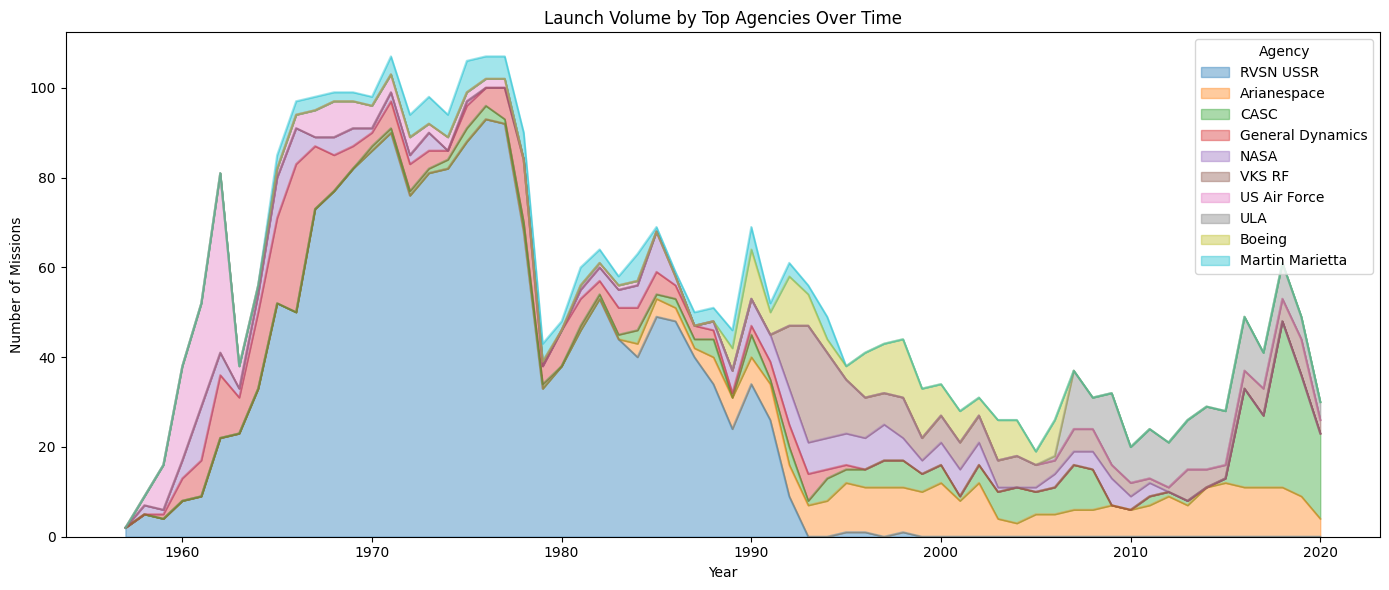

In [44]:
fig13 = agency_yearly_top.plot.area(figsize=(14, 6), alpha=0.4)
plt.title('Launch Volume by Top Agencies Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Missions')
plt.legend(title='Agency')
plt.tight_layout()
plt.show()

The decline of the RVSN USSR is seen to correlate with the dissolution of the USSR as expected. Around that time private agencies like Boeing and Martin Marietta led other agencies in the sheer number of missions launched in the 90's.

How about these companies funding for space explorations?

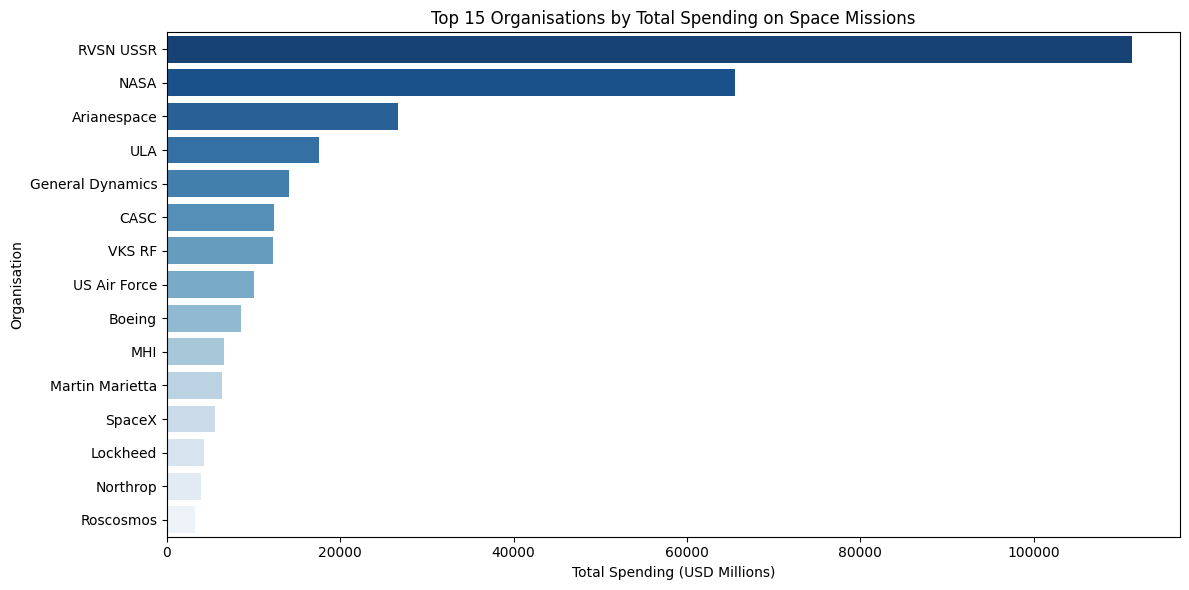

In [45]:
org_spending = missions_df.groupby('Organisation')['Price_Filled'].sum().sort_values(ascending=False).reset_index()
top_orgs = org_spending.head(15)

fig14 = plt.figure(figsize=(12, 6))
sns.barplot(data=top_orgs, x='Price_Filled', y='Organisation', palette='Blues_r', hue='Organisation', dodge=False, legend=False)
plt.title('Top 15 Organisations by Total Spending on Space Missions')
plt.xlabel('Total Spending (USD Millions)')
plt.ylabel('Organisation')
plt.tight_layout()
plt.show()

Price Filled column used for estimation as some countries funding data not available like those of the USSR.

The average money spent for launch only utilises the originally provided data.

In [46]:
avg_per_launch = missions_df[missions_df['Price'] > 0].groupby('Organisation')['Price'].mean().round(3).sort_values(ascending=False).reset_index()
top_avg = avg_per_launch.head(15)

top_avg

,Organisation,Price
0,NASA,450.000
1,Boeing,177.286
2,Arianespace,170.260
3,ULA,151.000
4,ILS,101.538
5,MHI,95.473
6,Martin Marietta,80.156
7,US Air Force,59.677
8,JAXA,56.000
9,SpaceX,54.990


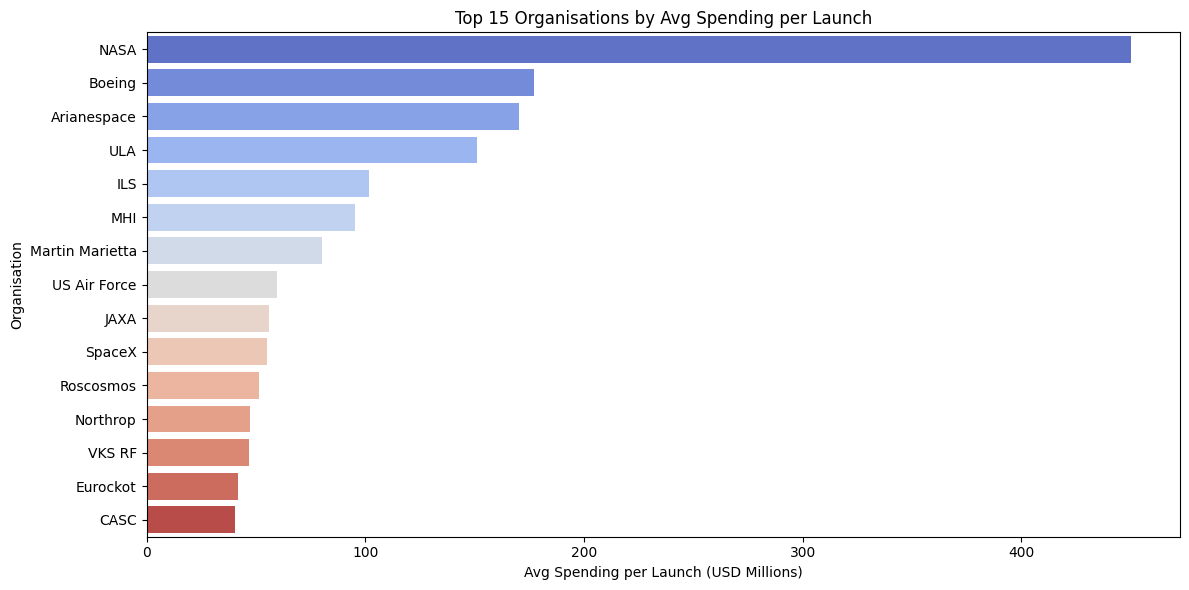

In [47]:
fig15 = plt.figure(figsize=(12, 6))
sns.barplot(data=top_avg, x='Price', y='Organisation', hue='Organisation', palette='coolwarm', dodge=False, legend=False)
plt.title('Top 15 Organisations by Avg Spending per Launch')
plt.xlabel('Avg Spending per Launch (USD Millions)')
plt.ylabel('Organisation')
plt.tight_layout()
plt.show()


#### Public and Private Funding

Visualising the effect of expenditure of government and private organisations

In [48]:
agg = missions_df.groupby(['Agency_Type', 'Country_Code', 'Organisation']).Price_Filled.sum().reset_index()

fig16 = px.sunburst(
    agg,
    path=['Agency_Type', 'Country_Code', 'Organisation'],
    values='Price_Filled',
    color='Agency_Type',
    color_discrete_map={'Private': '#636EFA', 'Government': '#FFA673'},
    title='Expenditure by Agency Type and Organisation'
)

fig16.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig16.show()

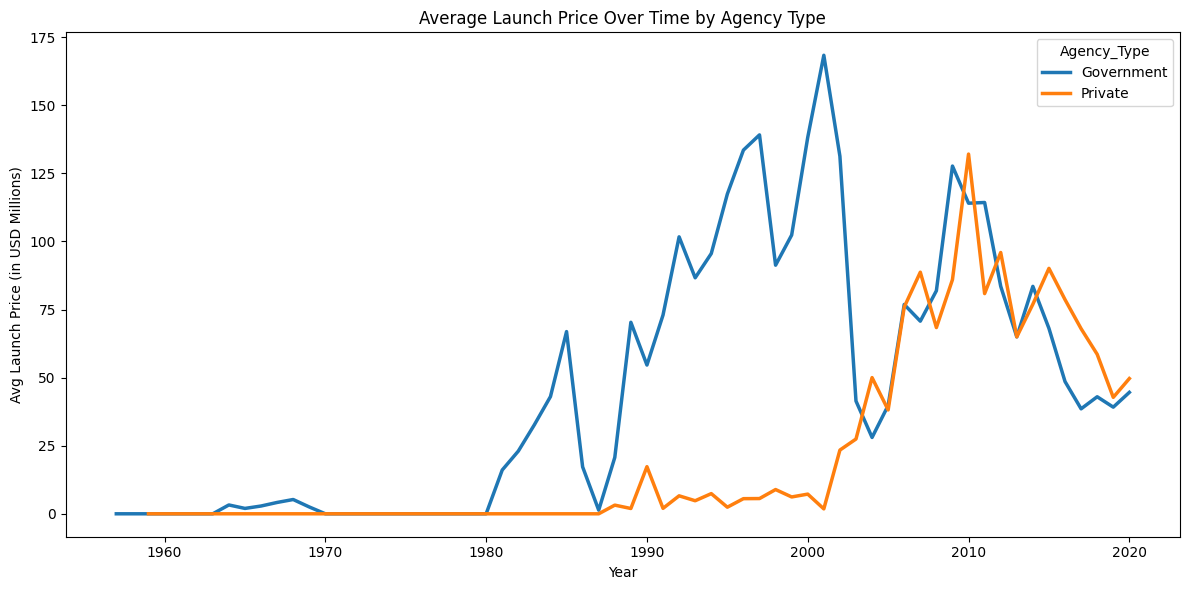

In [49]:
avg_price_agency = missions_df.groupby(['Year', 'Agency_Type'])['Price'].mean().reset_index()

fig17 = plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_agency, x='Year', y='Price', hue='Agency_Type', linewidth=2.5)
plt.title('Average Launch Price Over Time by Agency Type')
plt.xlabel('Year')
plt.ylabel('Avg Launch Price (in USD Millions)')
plt.tight_layout()
plt.show()

#### Launch Price Over  Time

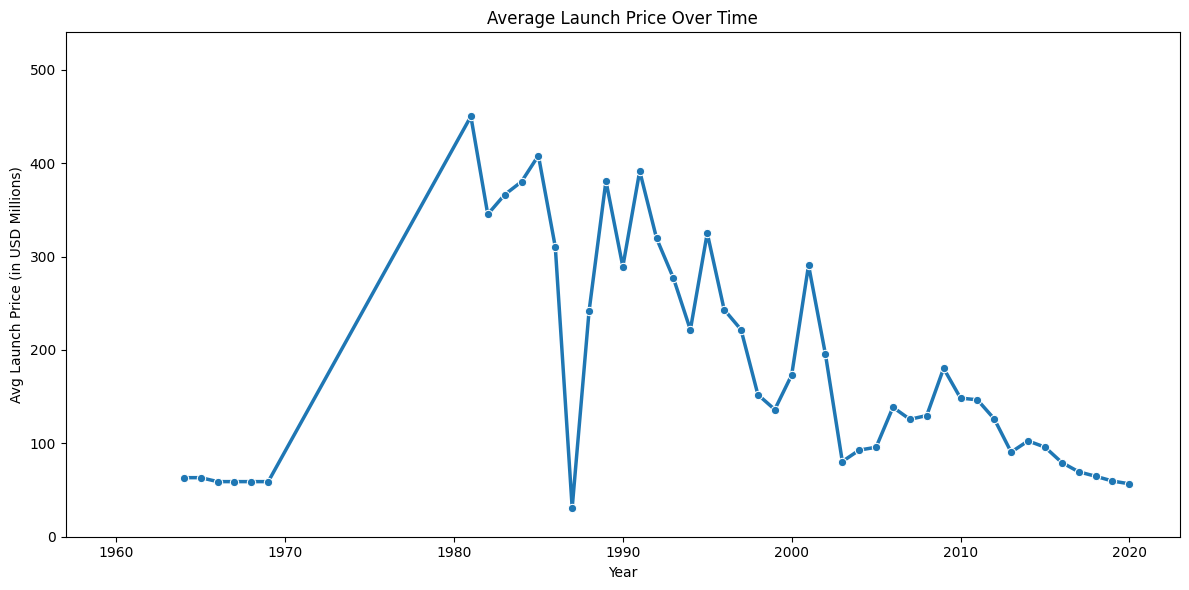

In [50]:
avg_price_per_year = missions_df[missions_df.Price != 0].groupby('Year')['Price'].mean().reset_index()

fig18 = plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_per_year, x='Year', y='Price', linewidth=2.5, marker='o')
plt.title('Average Launch Price Over Time')
plt.xlabel('Year')
plt.ylabel('Avg Launch Price (in USD Millions)')
plt.xlim(1957, avg_price_per_year['Year'].max()+3)
plt.ylim(0, avg_price_per_year['Price'].max() * 1.2) 

plt.tight_layout()
plt.show()


#### Number of Active vs Retired Rockets

In [51]:
rocket_status = missions_df.groupby('Rocket_Status').size().reset_index(name='Count')

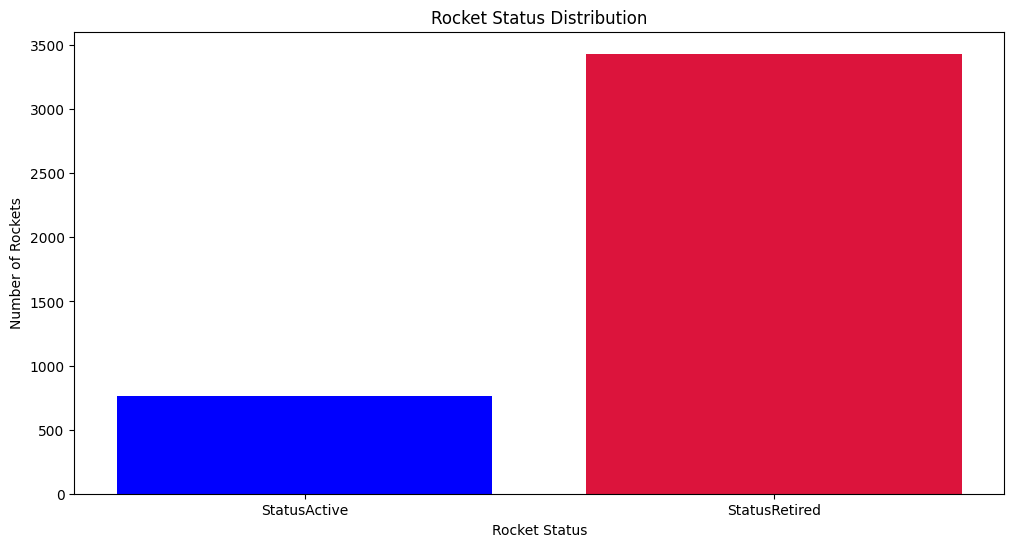

In [52]:
fig19 = plt.figure(figsize=(12, 6))
plt.bar(rocket_status['Rocket_Status'], rocket_status['Count'], color=['blue', 'crimson'])
plt.title('Rocket Status Distribution') 
plt.xlabel('Rocket Status')
plt.ylabel('Number of Rockets')
plt.show()